# 03 - Use a gridsearch to optimize hyperparameters for Vectorizing and modeling

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline

from sklearn.naive_bayes import MultinomialNB

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
# we may choose to only optimize for Tfidf bc this structures the data with more information 
from nltk.corpus import stopwords

### Preprocessing the text data

In [3]:
posts = pd.read_csv('./data/posts.csv')
posts = posts.fillna('')
posts['subreddit'] = posts['subreddit'].map({'TwoXChromosomes': 1, 'MensRights': 0})
posts.tail()

,created_utc,title,self_text,subreddit
5878,2012-12-17 11:09:52,The Physical and Psychological Differences Bet...,,0
5879,2012-12-06 12:14:14,FB yielded a good example of the double standa...,,0
5880,2012-11-04 04:44:44,Incident at work today (not a discrimination i...,So I work as a car salesman and today a well e...,0
5881,2019-04-28 20:05:06,"As a woman,","I really want to support your movement, and i ...",0
5882,2023-05-17 14:27:51,"""Dead-Beat Dads"" is a myth....","A long time ago, I copied something I found o...",0


In [4]:
posts.isnull().sum() # confirm data contains no null values

created_utc    0
title          0
self_text      0
subreddit      0
dtype: int64

In [5]:
# engineer a new feature that combines title and self text 'all_text'
# because oftentimes posts have no text body, and the title contains all the information
posts['all_text'] = posts['title'] + '\n\n' + posts['self_text']
posts['all_text']

0       What are some fashion choices men have given y...
1       I feel insane - IUD stories? \n\nHi all, I hav...
2       questions for anyone with the birth control ar...
3       Running Through Fear: Kosovar Women Jog In Gro...
4       I’m so sick of the low effort men put into the...
                              ...                        
5878    The Physical and Psychological Differences Bet...
5879    FB yielded a good example of the double standa...
5880    Incident at work today (not a discrimination i...
5881    As a woman,\n\nI really want to support your m...
5882    "Dead-Beat Dads" is a myth....\n\n A long time...
Name: all_text, Length: 5883, dtype: object

In [6]:
dropped = posts.drop(columns=['title', 'self_text'])
dropped = dropped[['created_utc', 'all_text', 'subreddit']]
dropped.head()

,created_utc,all_text,subreddit
0,2024-03-01 08:30:47,What are some fashion choices men have given y...,1
1,2024-03-01 07:56:51,"I feel insane - IUD stories? \n\nHi all, I hav...",1
2,2024-03-01 06:30:16,questions for anyone with the birth control ar...,1
3,2024-03-01 06:30:07,Running Through Fear: Kosovar Women Jog In Gro...,1
4,2024-03-01 06:22:10,I’m so sick of the low effort men put into the...,1


In [9]:
dropped = dropped.sample(frac=1, random_state=2043) # shuffled the concatenated dfs
dropped.to_csv('./data/posts_cleaned.csv', index=False)
dropped.head()

,created_utc,all_text,subreddit
454,2024-02-23 23:53:04,People are sometimes MORE prejudiced towards n...,1
5579,2022-11-13 21:53:21,PART 2 - CONSCRIPTION FOR MASS GENOCIDE? THE T...,0
202,2024-02-27 15:17:39,Why are there so few tall women in MMA?\n\nAs ...,1
3424,2024-02-09 21:42:21,97% of Women Endorse Touching Unwilling Men Af...,0
375,2024-02-25 11:33:15,No one wants to date me cos i’m too childish\n...,1


### Explore the cleaned data

In [10]:
# Start from here
posts = pd.read_csv('./data/posts_cleaned.csv')
posts.head()

,created_utc,all_text,subreddit
0,2024-02-23 23:53:04,People are sometimes MORE prejudiced towards n...,1
1,2022-11-13 21:53:21,PART 2 - CONSCRIPTION FOR MASS GENOCIDE? THE T...,0
2,2024-02-27 15:17:39,Why are there so few tall women in MMA?\n\nAs ...,1
3,2024-02-09 21:42:21,97% of Women Endorse Touching Unwilling Men Af...,0
4,2024-02-25 11:33:15,No one wants to date me cos i’m too childish\n...,1


In [11]:
posts.subreddit.mean() # 0.50 means balanced classes which is good for binary classification

0.504164541900391

We calculated the percentage of total posts which were from TwoXChromosomes to be about 50.4% which means that our classes are balanced in this dataset.  This percentage represents the baseline score. For example, if we had a completely untrained classification model, the best guess is simply the percentage occurrence of that class in the dataset.  We aim to produce a model which classifies a post more intelligently than guessing 50-50.

In [12]:
X = posts['all_text']
y = posts['subreddit']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [14]:
# Set up a pipeline with two stages:
# 1. CountVectorizer (transformer)
# 2. Multinomial Naive Bayes (estimator)

# Given the warning in CountVectorizer that their stop_words for 'english' are not great, we use the nltk library stop_words
sw = stopwords.words('english')

pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

params = {
    'cvec__stop_words' :[None, sw],
    # 'cvec__binary': [False, True],
    'cvec__min_df': [1, 2],
    # 'cvec__max_df: [0.98]
    'cvec__ngram_range': [(1, 1), (1, 2), (2, 3)],
    'cvec__max_features': [1000, 2000, 3000, None],
}

gs = GridSearchCV(pipe, params, n_jobs=8)

In [15]:
%%time
gs.fit(X_train, y_train)

CPU times: user 2.75 s, sys: 1.69 s, total: 4.44 s
Wall time: 1min 28s


GridSearchCV(estimator=Pipeline(steps=[('cvec', CountVectorizer()),
                                       ('nb', MultinomialNB())]),
             n_jobs=8,
             param_grid={'cvec__max_features': [1000, 2000, 3000, None],
                         'cvec__min_df': [1, 2],
                         'cvec__ngram_range': [(1, 1), (1, 2), (2, 3)],
                         'cvec__stop_words': [None,
                                              ['i', 'me', 'my', 'myself', 'we',
                                               'our', 'ours', 'ourselves',
                                               'you', "you're", "you've",
                                               "you'll", "you'd", 'your',
                                               'yours', 'yourself',
                                               'yourselves', 'he', 'him', 'his',
                                               'himself', 'she', "she's", 'her',
                                               'hers', 'herself', 'it', "it's",
                                               'its', 'itself', ...]]})

In [17]:
columns = gs.best_estimator_[0].get_feature_names_out()
columns[-10:]

array(['zero issues', 'zero reason', 'zero sense', 'zero sum',
       'zimmerman', 'zipper', 'zombie', 'zone', 'zones', 'zoom'],
      dtype=object)

In [18]:
cv_fit = gs.best_estimator_[0].transform(X_train)

In [20]:
result_df = pd.DataFrame(data = cv_fit.toarray(), columns=columns)
result_df.head()

,00,000,000 000,000 planned,000 usd,000 year,01,01 31,01 sotomayor,01 women,...,zero issues,zero reason,zero sense,zero sum,zimmerman,zipper,zombie,zone,zones,zoom
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [23]:
term_freq = np.sum(result_df, axis=0)

In [41]:
most_common = term_freq.sort_values(ascending=False).head(10)

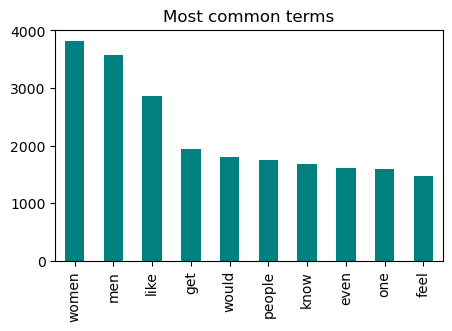

In [50]:
plt.figure(figsize=(5,3))
plt.title('Most common terms')
most_common.plot(kind='bar', color='teal');

In [ ]:
# HERE
# RELEVANT EDA - consult 405-classification metrics to discuss the confusion matrix and to plot distributions, consult 502-lab-nlp to see what kind of EDA
gs.best_params_

In [ ]:
pd.DataFrame(gs.cv_results_).sort_values('mean_test_score', ascending=False)[:5]

In [ ]:
gs.score(X_train, y_train)

In [ ]:
gs.score(X_test, y_test)

In [ ]:
y_hat = gs.predict(X_test)
confusion_matrix(y_test, y_hat)

In [ ]:
ConfusionMatrixDisplay.from_estimator(gs, X_test, y_test, cmap='Blues');

This model is bad.  Discuss the accuracy, specificity, sensitivity, precision here.

In [ ]:
# Examine the best params
gs.best_params_

In [ ]:
sw

In [ ]:
gs.best_estimator_

In [ ]:
gs.best_index_

In [ ]:
gs.best_score_

The model is bad.  But the best estimator in this gridsearch removed stopwords, so we keep it in the model.  Or, rather, let's build this up from smaller grid searches. Or, utitilzie random search to cover hyperparamter space more efficiently.

In [ ]:
# Given the warning in CountVectorizer that their stop_words for 'english' are not great, we use the nltk library stop_words
sw = stopwords.words('english')

pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

params = {
    'cvec__stop_words' :[sw],
    # 'cvec__binary': [False, True],
    'cvec__min_df': [1, 2],
    # 'cvec__max_df: [0.98]
    'cvec__ngram_range': [(1,1), (1,2), (1, 3)],
    # 'cvec__max_features': [2000, 3000, None],
}

gs = GridSearchCV(pipe, params, n_jobs=4)

In [ ]:
%%time
gs.fit(X_train, y_train)

In [ ]:
gs.score(X_train, y_train)

In [ ]:
gs.score(X_test, y_test)

In [ ]:
ConfusionMatrixDisplay.from_estimator(gs, X_test, y_test, cmap='Blues');

In [ ]:
gs.best_params_

In [ ]:
# Given the warning in CountVectorizer that their stop_words for 'english' are not great, we use the nltk library stop_words
sw = stopwords.words('english')

pipe = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB())
])

params = {
    'cvec__stop_words' :[None],
    # 'cvec__binary': [False, True],
    'cvec__min_df': [1, 2],
    # 'cvec__max_df: [0.98]
    'cvec__ngram_range': [ (1,2)],
    'cvec__max_features': [2000, 3000, None],
}

gs = GridSearchCV(pipe, params, n_jobs=4)

In [ ]:
%%time
gs.fit(X_train, y_train)

In [ ]:
gs.best_params_

In [ ]:
gs.score(X_train, y_train)

In [ ]:
gs.score(X_test, y_test)